## EDA usando R 
Se usan las funciones de clases

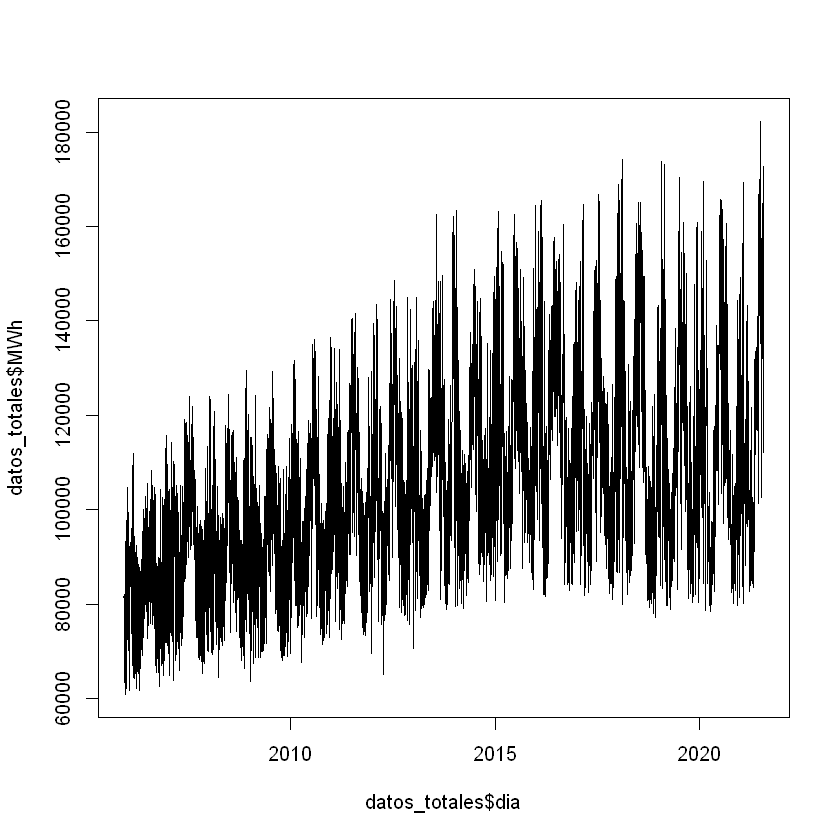

In [28]:
x <- 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/master/datasets/consumo_energetico_diario.csv'
datos_totales <- read.csv(file = x)
datos_totales$dia<- as.Date(datos_totales$dia)

plot(datos_totales$dia,datos_totales$MWh,type='l')

In [2]:
library(wavethresh)

Loading required package: MASS

WaveThresh: R wavelet software, release 4.6.9, installed


Copyright Guy Nason and others 1993-2018


Note: nlevels has been renamed to nlevelsWT




Se observa que el consumo de electricidad además de su variación va aumento su tendencia de consumo y la amplitud de las oscilaciones. 

Por simplicidad en esta notebook se usan los datos desde 2013 en adelante.

Además se busca predecir el consumo a partir de 2020, por lo cual no se analizan dichos datos

[1] "dia" "MWh" "TMP"
[1] "La cantidad de muestras N =2556"


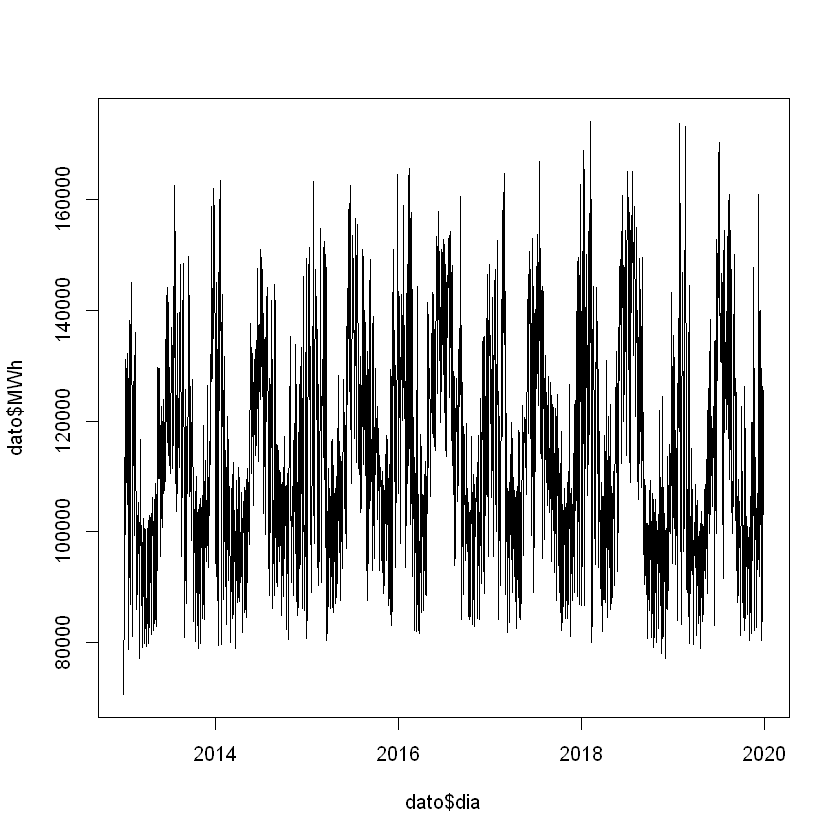

In [29]:
dato<-datos_totales[(datos_totales$dia>'2012-12-31')&(datos_totales$dia<'2020-01-01'),]
print(names(dato))

N<-dim(dato)[1]
print(paste0('La cantidad de muestras N =', N))
# [1] "X" "t" "a0" "a1" "a2" "rn" "a"

op <- par(mfrow = c(1, 1))

plot(dato$dia,dato$MWh,type='l')

### Media móvil

Uso dos filtros de Media móvil. Con el primero saco la tendencia y el segundo filtra a nivel mensual

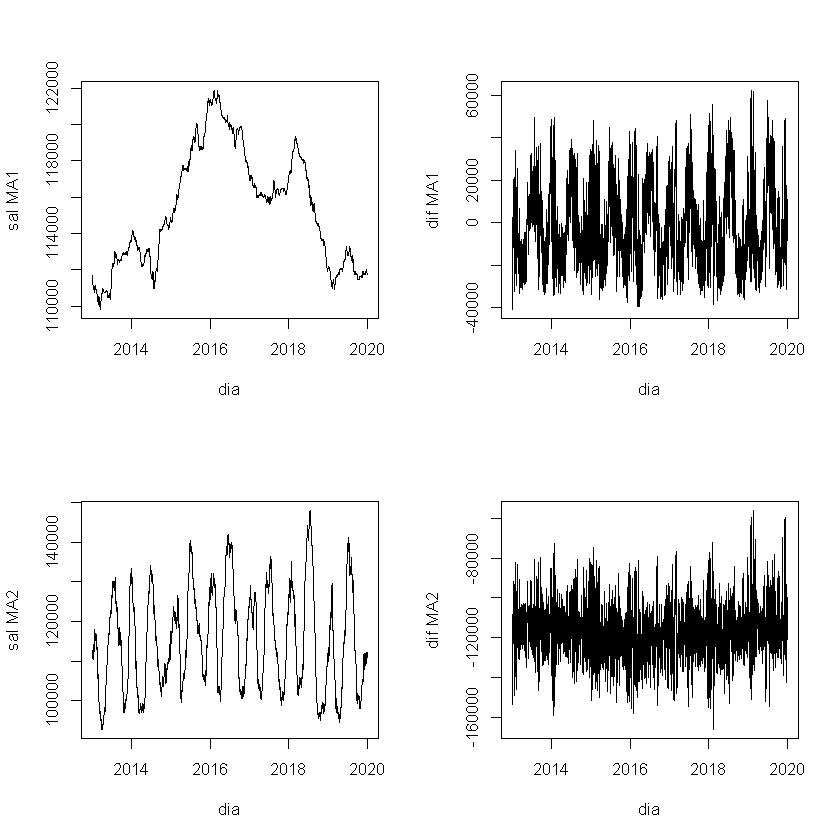

In [4]:
outMA1 <- stats::filter(dato$MWh, rep(1/365,365), circular =TRUE)
difMA1 <- dato$MWh - outMA1
outMA2 <- stats::filter(dato$MWh, rep(1/(30),30), circular =TRUE)
difMA2 <- difMA1 - outMA2 #otra opcion es restarle el outMA2 a dato$MWh 

op <- par(mfrow = c(2, 2))
plot(dato$dia, outMA1, type='l', xlab='dia', ylab='sal MA1')
plot(dato$dia, difMA1, type='l' , xlab='dia', ylab='dif MA1')
plot(dato$dia, outMA2, type='l', xlab='dia', ylab='sal MA2')
plot(dato$dia, difMA2, type='l', xlab='dia', ylab='dif MA2')

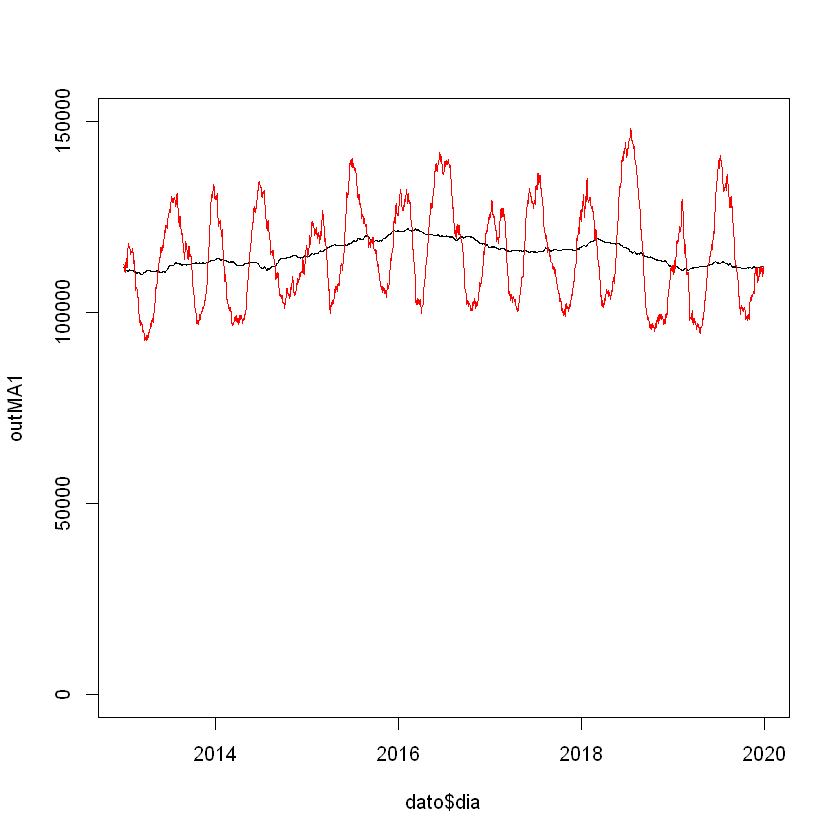

In [5]:
op <- par(mfrow = c(1, 1))
plot(dato$dia,outMA1, type='l', ylim=c(-10,150000))#, xlab='dia', ylab='sal−dif MA1 y MA2', col='black')
#lines(dato$dia,difMA1, col='blue')
lines(dato$dia,outMA2, col='red')
#lines(dato$dia,difMA2, col='green')

En negro, la media móvil anual, rojo la media móvil mensual

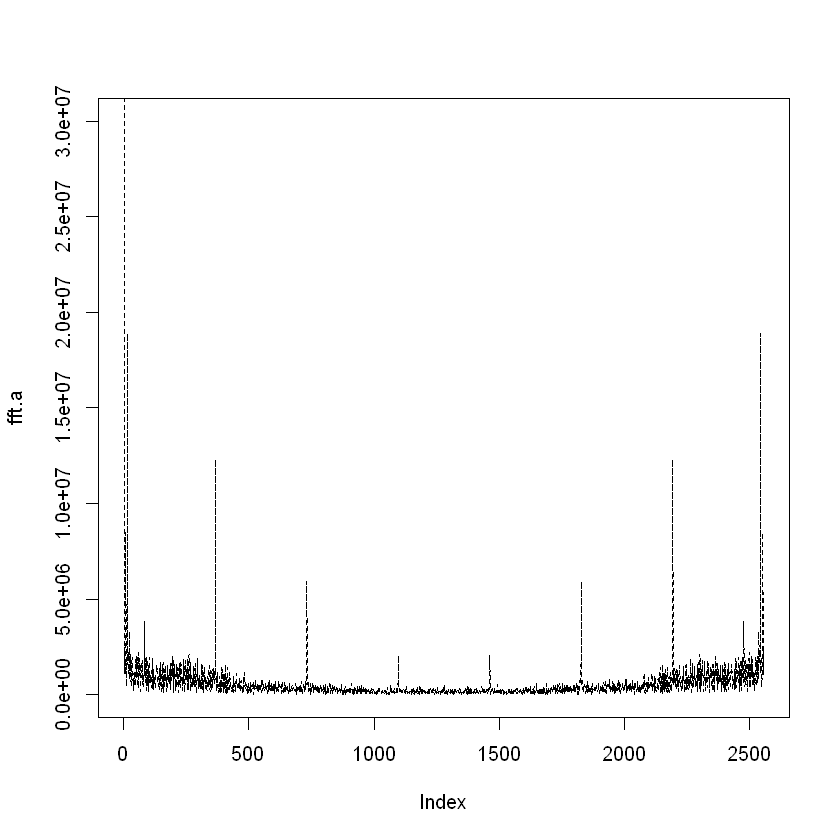

In [6]:
fft.a = Mod(fft(dato$MWh))

fft.outMA1 = Mod(fft(outMA1))
fft.difMA1 = Mod(fft(difMA1))
fft.outMA2 = Mod(fft(outMA2))
fft.difMA2 = Mod(fft(difMA2))

op <- par(mfrow = c(1, 1))
plot( fft.a, type='l', col='black', lty=2,ylim=c(0,3e7)) #, xlim=c(0,128)
#lines( fft.outMA1, col='blue')
#lines( fft.outMA2, col='red')


Para pasar el eje de abscisas a frecuencia, la ecuación sería f = i * Fs / N, for i = 0, 1, 2, ..., N-1 (i< N/2)

En este caso la frecuencia de muestreo es fs=1 (dia^-1)=1/86400 Hz=1.157407e-05 Hz (conviene usarlo en unidad de (dia^-1))

In [7]:
indices <- which(fft.a %in% rev(sort(fft.a))[1:10])
idx<-indices[indices<N/2]
fs<-1 #(dia-1), frecuencia diaria
maximos_fft_original<-data.frame(idx,fs*(idx-1)/N, N/(fs*idx),fft.a[idx])
colnames(maximos_fft_original)<-c('indice','frecuencia (1/dia)','periodo (dia)', 'abs(fft)')

maximos_fft_original

#indices <- which(fft.outMA2 %in% rev(sort(fft.outMA2))[1:10])
#idx<-indices[indices<N/2]
#maximos_fft_MA2<-data.frame(idx,fft.outMA2[idx])

indice,frecuencia (1/dia),periodo (dia),abs(fft)
<int>,<dbl>,<dbl>,<dbl>
1,0.000000000,2556.000000,294912630
8,0.002738654,319.500000,8495854
15,0.005477308,170.400000,18904844
366,0.142801252,6.983607,12296795
731,0.285602504,3.496580,5922942


Tengo componente de continua y senoidales con frecuencia casi semestral (170), semanal (7) y bianual (731) 

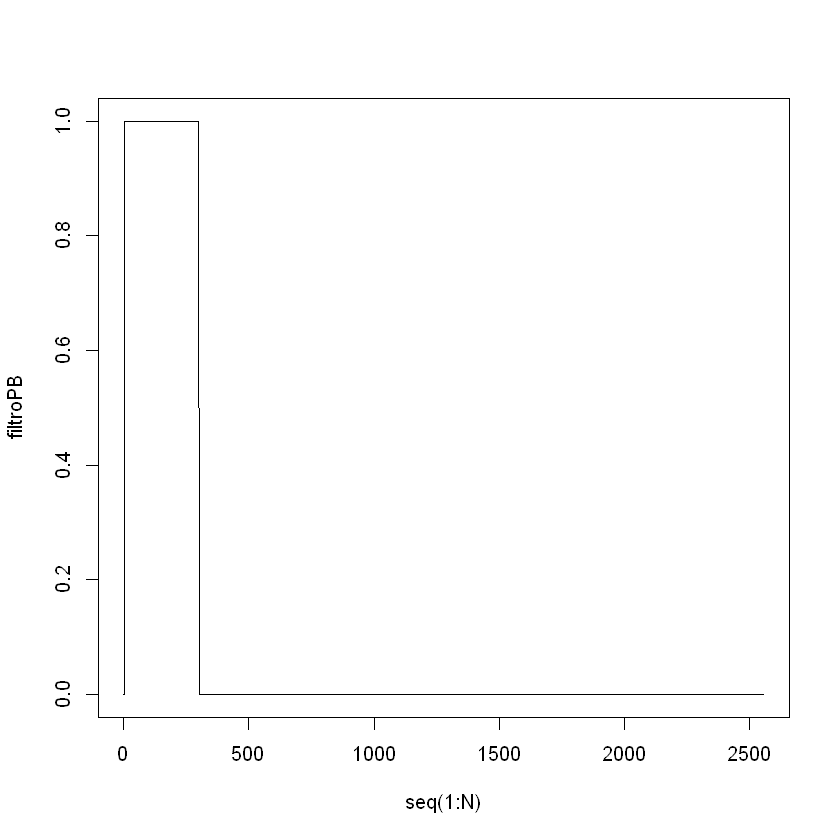

In [8]:
# filtro pasabanda
filtroPB = rep(0,N)
banda.filtro1 = 4
banda.filtro2= 300#500
filtroPB[banda.filtro1:banda.filtro2] = 1
plot(seq(1:N), filtroPB ,type='l')

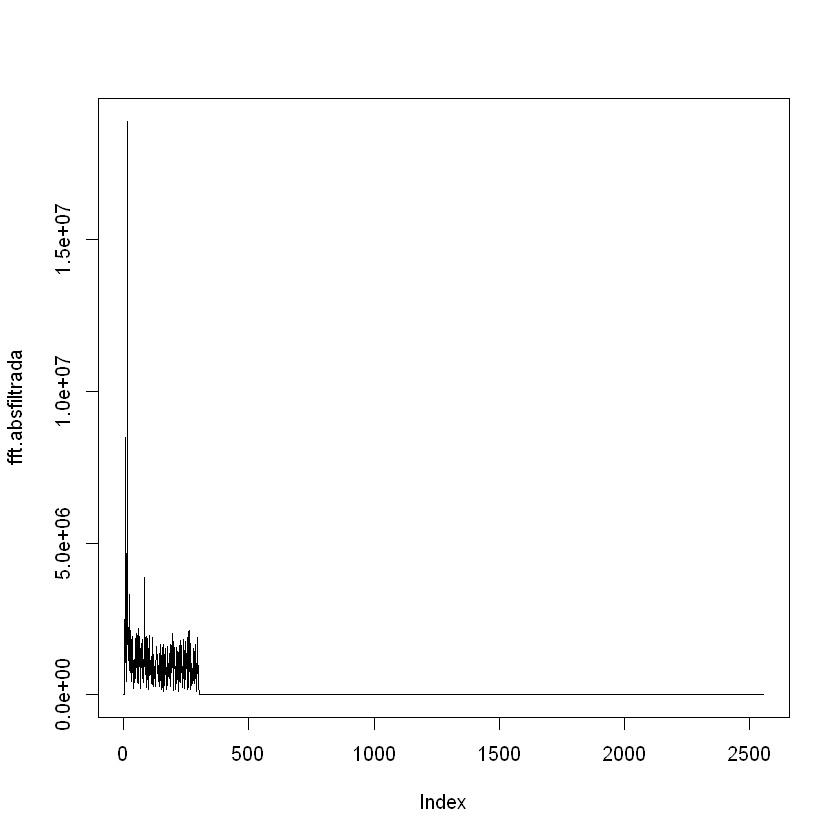

In [9]:
fft.filtrada = filtroPB*fft.a #filtro la señal con pasabajo discreto
fft.absfiltrada = Mod(fft.filtrada)
plot(fft.absfiltrada, type='l')

In [10]:
indices <- which(fft.absfiltrada %in% rev(sort(fft.absfiltrada))[1:3])
idx<-indices[indices<N/2]
maximos_fft_filtrada<-data.frame(idx,fft.absfiltrada[idx])
fs<-1 #(dia-1), frecuencia diaria
maximos_fft_filtrada<-data.frame(idx,fs*(idx-1)/N, N/(fs*idx),fft.outMA1[idx])
colnames(maximos_fft_filtrada)<-c('indice','frecuencia (1/dia)','periodo (dia)', 'abs(fft)')

maximos_fft_filtrada

indice,frecuencia (1/dia),periodo (dia),abs(fft)
<int>,<dbl>,<dbl>,<dbl>
8,0.002738654,319.50000,3325.228
15,0.005477308,170.40000,7399.514
82,0.031690141,31.17073,103785.962


### Autocorrelación
La autocorrelación de la señal me permite interpretar que la señal original tiene periodicidad y ruido. 

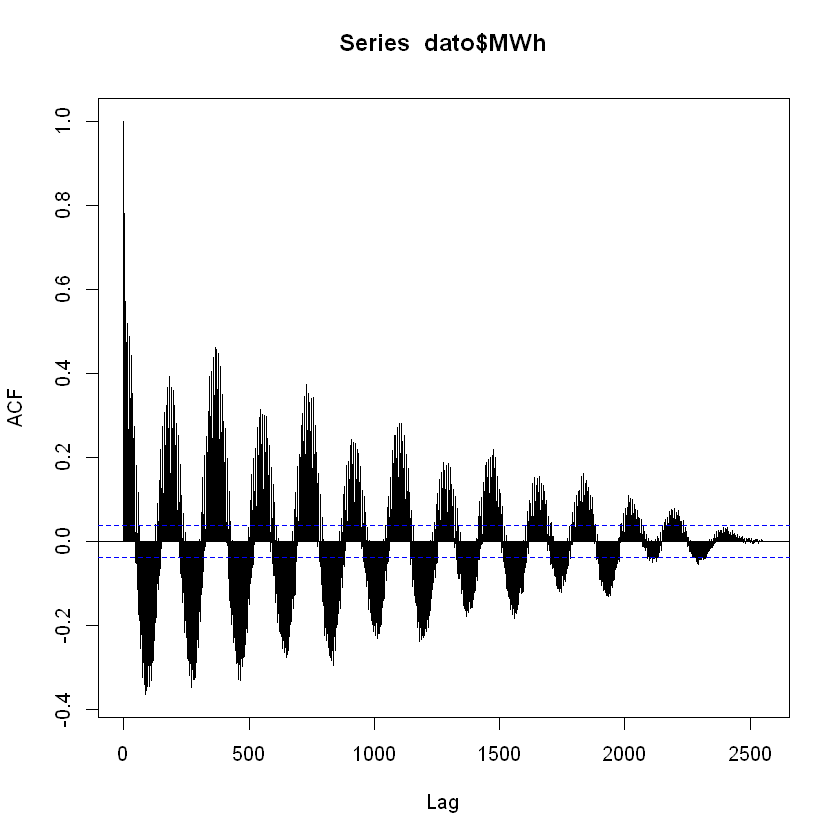

In [11]:
acf(dato$MWh, lag.max = N)

### Wavelets

In [38]:
dato<-datos_totales[(datos_totales$dia<'2020-01-01'),]
print(names(dato))

N_dato<-dim(dato)[1]

N=2^12
sAB<-dato$MWh[1049:5144]
tiempo<-seq(1:4096)#dato[1049:5144,1]

print(paste0('La cantidad de muestras elegidas es N =', N))

[1] "dia" "MWh" "TMP"
[1] "La cantidad de muestras elegidas es N =4096"


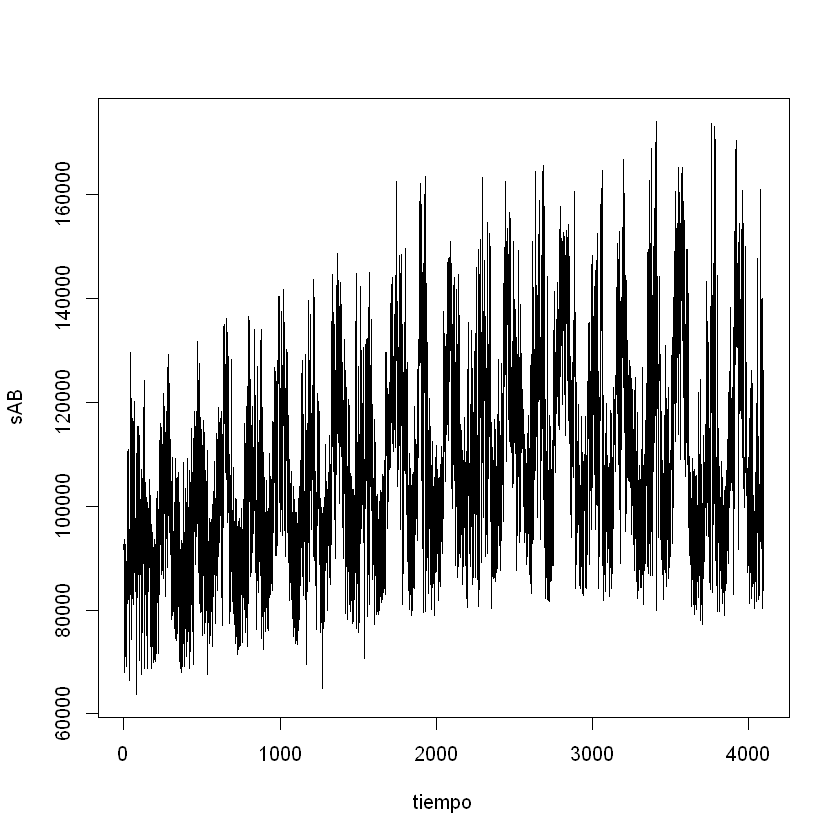

In [40]:
plot(tiempo,sAB, type='l', ylab ='sAB')

[1] 440655.2 440655.2 440655.2 440655.2 440655.2 440655.2 440655.2 440655.2
 [9] 440655.2 440655.2 440655.2 440655.2

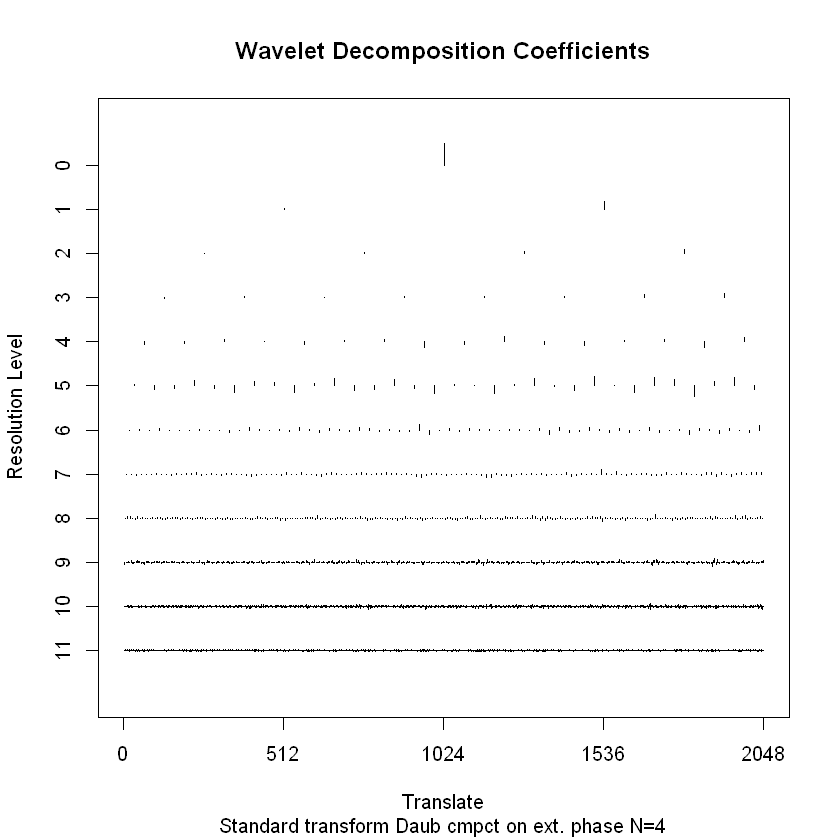

In [41]:
wd.sAB = wd(sAB, filter.number = 4, family = "DaubExPhase")
plot(wd.sAB)

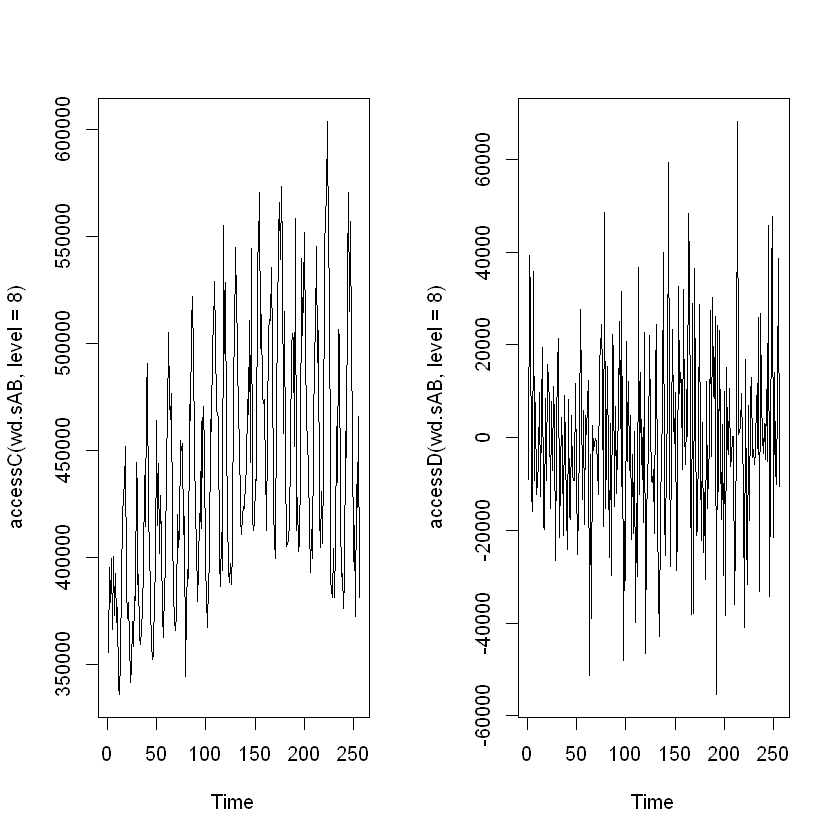

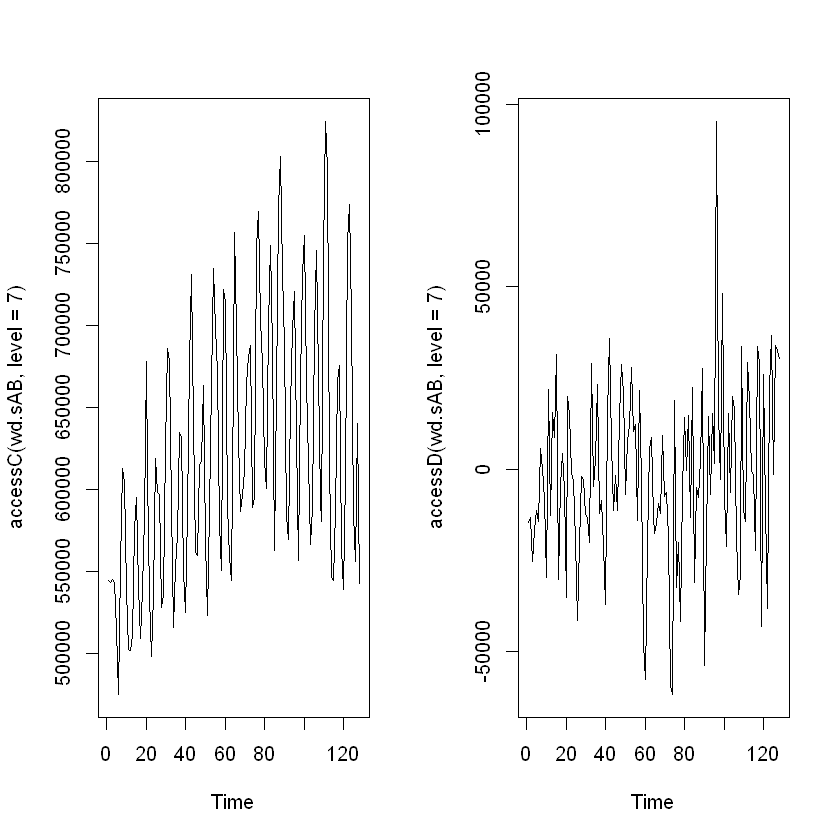

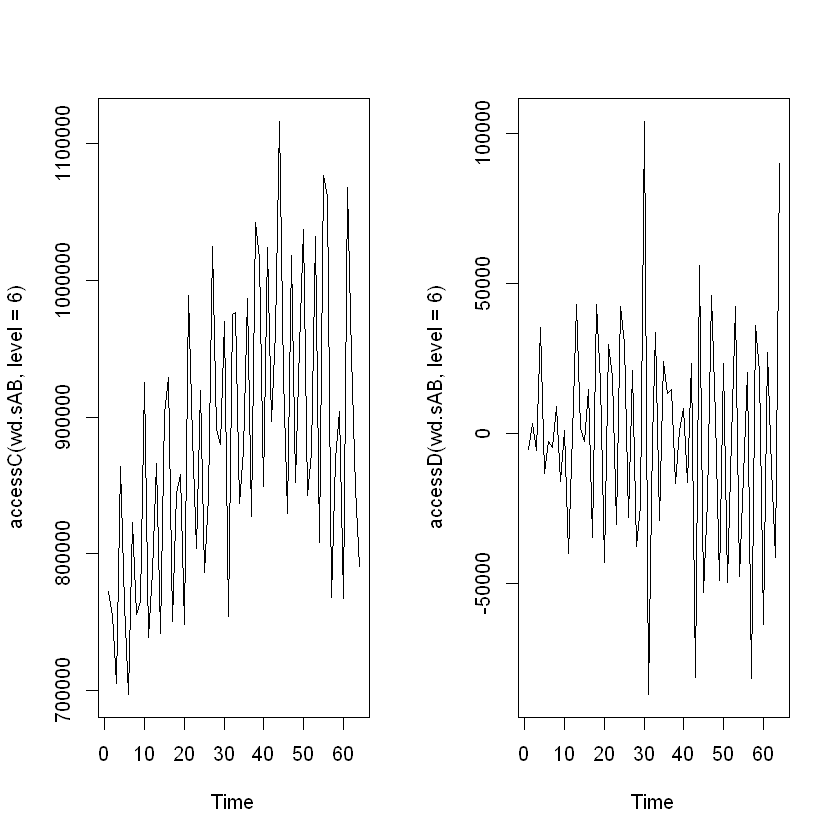

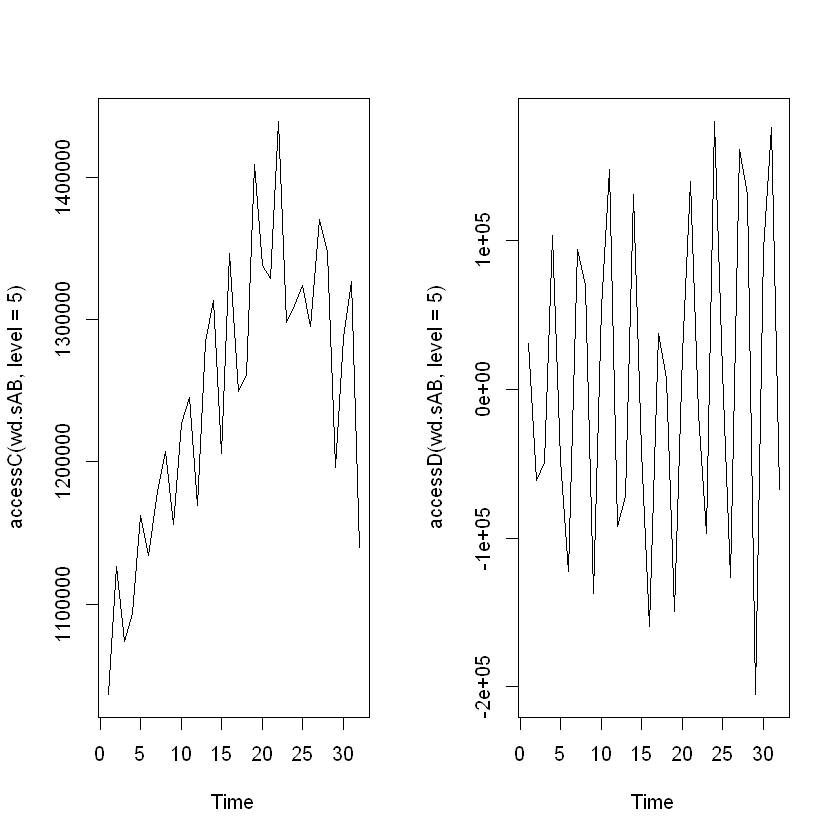

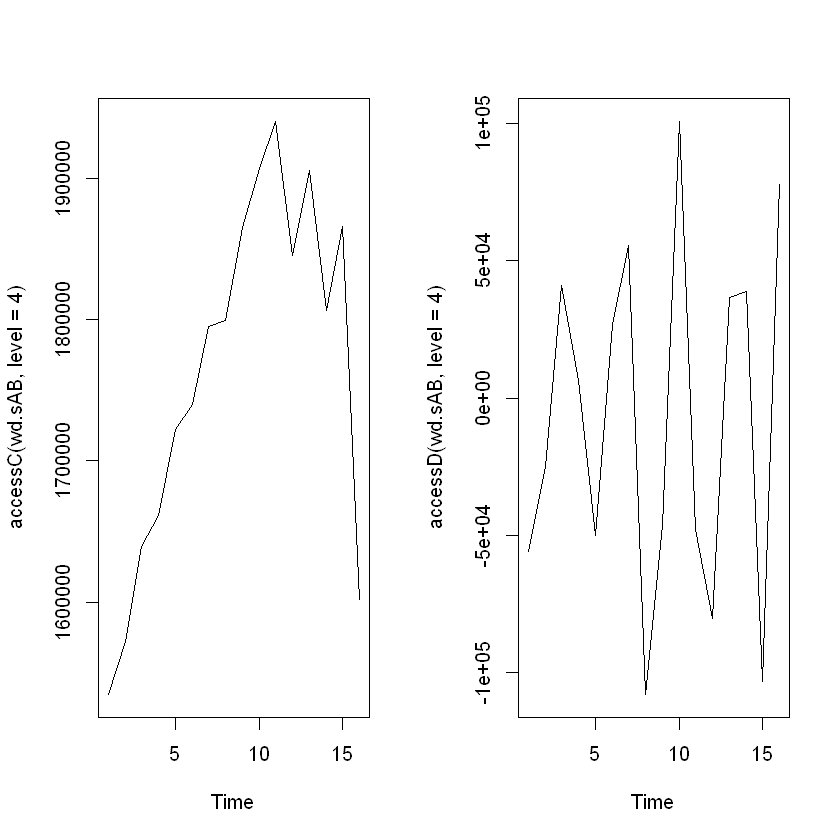

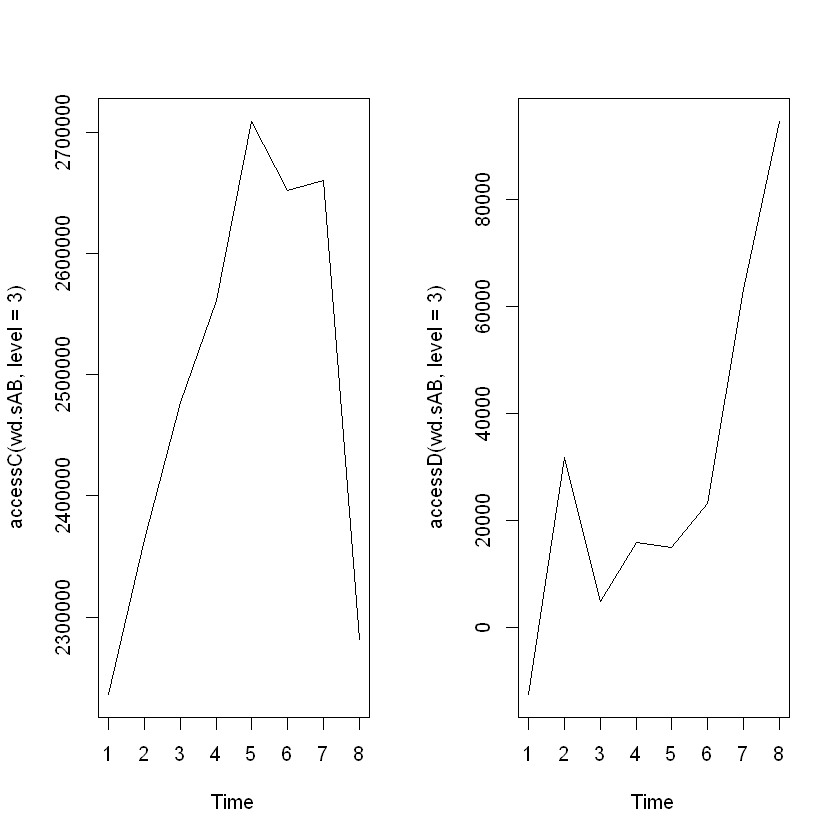

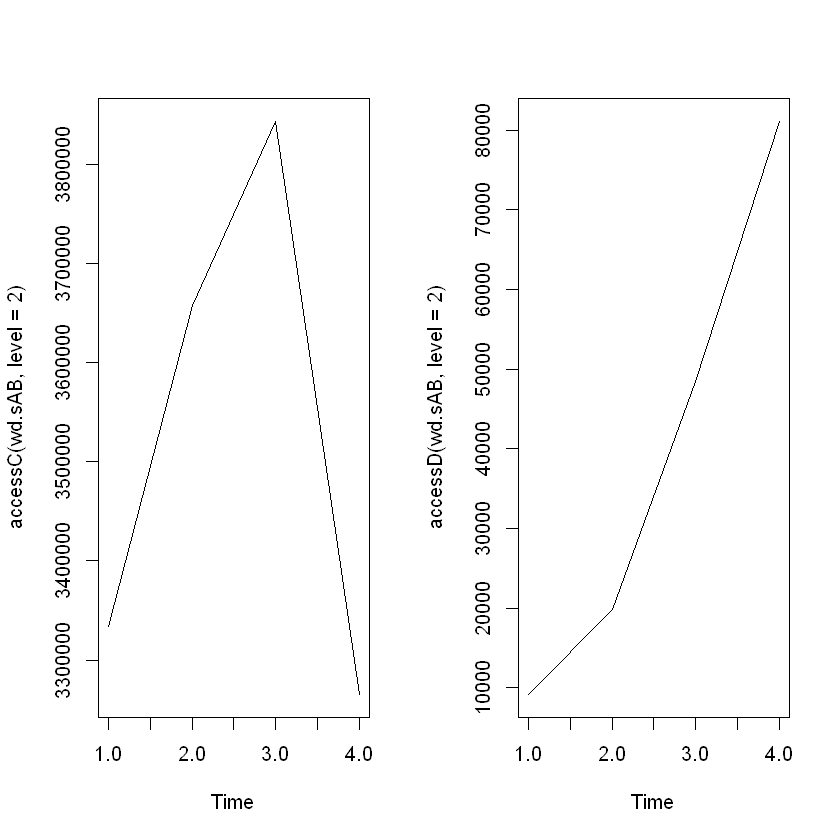

In [42]:
par(mfrow = c(1, 2))
plot.ts(accessC(wd.sAB, level = 8))
plot.ts(accessD(wd.sAB, level = 8))

par(mfrow = c(1, 2))
plot.ts(accessC(wd.sAB, level = 7))
plot.ts(accessD(wd.sAB, level = 7))

par(mfrow = c(1, 2))
plot.ts(accessC(wd.sAB, level = 6))
plot.ts(accessD(wd.sAB, level = 6))

par(mfrow = c(1, 2))
plot.ts(accessC(wd.sAB, level = 5))
plot.ts(accessD(wd.sAB, level = 5))

par(mfrow = c(1, 2))
plot.ts(accessC(wd.sAB, level = 4))
plot.ts(accessD(wd.sAB, level = 4))

par(mfrow = c(1, 2))
plot.ts(accessC(wd.sAB, level = 3))
plot.ts(accessD(wd.sAB, level = 3))

par(mfrow = c(1, 2))
plot.ts(accessC(wd.sAB, level = 2))
plot.ts(accessD(wd.sAB, level = 2))